<a href="https://colab.research.google.com/github/RansomwareDetection/RamsomwareTrafficDetection/blob/colab/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [2/20], Loss: 0.7292
Epoch [4/20], Loss: 0.7266
Epoch [6/20], Loss: 0.7241
Epoch [8/20], Loss: 0.7212
Epoch [10/20], Loss: 0.7188
Epoch [12/20], Loss: 0.7159
Epoch [14/20], Loss: 0.7132
Epoch [16/20], Loss: 0.7101
Epoch [18/20], Loss: 0.7072
Epoch [20/20], Loss: 0.7045
Accuracy on the test set: 100.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

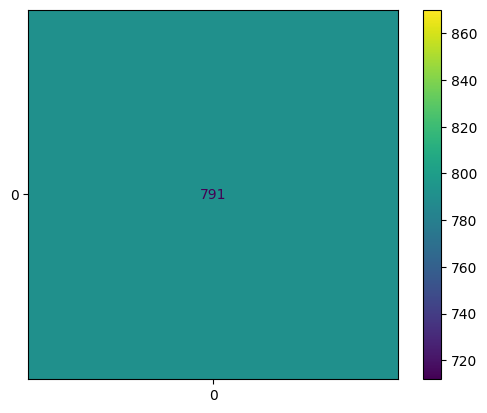

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the dataset
data = pd.read_csv("/content/Android_Ransomeware.csv")

# Step 2: Select columns that are relevant to network traffic
selected_columns = [' ACK Flag Count', ' Fwd Header Length.1', ' Avg Bwd Segment Size', ' Avg Fwd Segment Size', ' Average Packet Size', ' Down/Up Ratio', ' ECE Flag Count', ' CWE Flag Count', ' URG Flag Count', ' PSH Flag Count', 'Fwd Packets/s', ' RST Flag Count', ' SYN Flag Count', 'FIN Flag Count', ' Packet Length Variance', ' Packet Length Std', ' Packet Length Mean', ' Max Packet Length', ' Min Packet Length', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Idle Max', ' Idle Std', 'Idle Mean', ' Active Min', ' Active Max','Active Std']

data['Label'] = data['Label'].apply(lambda x: 0 if x != 'RansomBO' else 1)

# Step 3: Select the features (X) and target (y)
X = data[selected_columns[:-1]]  # All columns except 'Label'
y = data['Label']

# Step 4: Convert all columns to numeric and handle missing values
X = X.apply(pd.to_numeric, errors='coerce')  # Convert to numeric and set invalid values to NaN
X = X.fillna(X.mean())  # Fill NaN values with column means

# Ensure X is a NumPy array
X = X.to_numpy()  # Convert DataFrame to NumPy array

# Step 5: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 6: Reshape the input data to fit CNN (batch_size, channels, height, width)
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1], 1)  # (N, C, H, W)

# Step 7: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 8: Convert labels to one-hot encoding
y_train_onehot = F.one_hot(torch.tensor(y_train.to_numpy(), dtype=torch.long), num_classes=2)
y_test_onehot = F.one_hot(torch.tensor(y_test.to_numpy(), dtype=torch.long), num_classes=2)

# Step 9: Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = y_train_onehot.float()  # One-hot encoded labels should be floats for BCE
y_test_tensor = y_test_onehot.float()

# Step 10: Define the CNN Model
class MalwareDetectionCNN(nn.Module):
    def __init__(self):
        super(MalwareDetectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 1))
        self.dropout = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()

        # Calculate the size of the flattened input after conv and pooling layers
        self.flatten_size = self._get_flatten_size(X_train_tensor)

        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.fc2 = nn.Linear(64, 2)  # Output layer for binary classification

    def _get_flatten_size(self, sample_input):
        with torch.no_grad():
            x = self.conv1(sample_input)
            x = self.pool(x)
            x = self.conv2(x)
            x = self.pool(x)
            x = x.view(x.size(0), -1)  # Flatten
        return x.size(1)  # Get the flattened size of a single sample

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return torch.sigmoid(x)  # Sigmoid for binary classification output

# Step 11: Initialize the neural network, define loss function and optimizer
model = MalwareDetectionCNN()
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy for one-hot labels
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Step 12: Train the Neural Network
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Step 13: Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    test_outputs = model(X_test_tensor)
    predicted = torch.argmax(test_outputs, dim=1)  # Get predicted class
    y_test_classes = torch.argmax(y_test_tensor, dim=1)  # Convert one-hot to class labels
    accuracy = (predicted == y_test_classes).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

# Step 14: Confusion matrix
cm = confusion_matrix(y_test_classes, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Ransomware', 'Ransomware'])
disp.plot()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the dataset
data = pd.read_csv("/content/Android_Ransomeware.csv")

# Step 1: Filter dataset to include only "Benign" and "RansomBO" samples
data = data[data['Label'].isin(['Benign', 'RansomBO'])]


# Step 2: Convert 'Label' to 0 for 'Benign' and 1 for 'RansomBO'
data['Label'] = data['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

# Step 3: Select the columns that are relevant to network traffic
selected_columns = [' ACK Flag Count', ' Fwd Header Length.1', ' Avg Bwd Segment Size', ' Avg Fwd Segment Size',
                    ' Average Packet Size', ' Down/Up Ratio', ' ECE Flag Count', ' CWE Flag Count', ' URG Flag Count',
                    ' PSH Flag Count', 'Fwd Packets/s', ' RST Flag Count', ' SYN Flag Count', 'FIN Flag Count',
                    ' Packet Length Variance', ' Packet Length Std', ' Packet Length Mean', ' Max Packet Length',
                    ' Min Packet Length', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate',
                    ' Bwd Avg Bytes/Bulk', ' Idle Max', ' Idle Std', 'Idle Mean', ' Active Min', ' Active Max']

# Step 4: Select the features (X) and target (y)
X = data[selected_columns]  # All columns except 'Label'
y = data['Label']

# Step 5: Convert all columns to numeric and handle missing values
X = X.apply(pd.to_numeric, errors='coerce')  # Convert to numeric and set invalid values to NaN
X = X.fillna(X.mean())  # Fill NaN values with column means

# Ensure X is a NumPy array
X = X.to_numpy()  # Convert DataFrame to NumPy array

# Step 6: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Reshape the input data to fit CNN (batch_size, channels, height, width)
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1], 1)  # (N, C, H, W)

# Step 8: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 9: Convert labels to one-hot encoding
y_train_onehot = F.one_hot(torch.tensor(y_train.to_numpy(), dtype=torch.long), num_classes=2)
y_test_onehot = F.one_hot(torch.tensor(y_test.to_numpy(), dtype=torch.long), num_classes=2)

# Step 10: Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = y_train_onehot.float()  # One-hot encoded labels should be floats for BCE
y_test_tensor = y_test_onehot.float()

# Step 11: Define the CNN Model
class MalwareDetectionCNN(nn.Module):
    def __init__(self):
        super(MalwareDetectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 1))
        self.dropout = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()

        # Calculate the size of the flattened input after conv and pooling layers
        self.flatten_size = self._get_flatten_size(X_train_tensor)

        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.fc2 = nn.Linear(64, 2)  # Output layer for binary classification

    def _get_flatten_size(self, sample_input):
        with torch.no_grad():
            x = self.conv1(sample_input)
            x = self.pool(x)
            x = self.conv2(x)
            x = self.pool(x)
            x = x.view(x.size(0), -1)  # Flatten
        return x.size(1)  # Get the flattened size of a single sample

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return torch.sigmoid(x)  # Sigmoid for binary classification output
# Count the number of samples for each class
# Count the number of samples for each class
class_counts = data['Label'].value_counts()

benign_count = class_counts[0]  # Count of 'Benign' samples (label = 0)
ransom_count = class_counts[1]  # Count of 'RansomBO' samples (label = 1)

# Calculate the pos_weight for the 'RansomBO' class (minority class)
pos_weight = torch.tensor(benign_count / ransom_count, dtype=torch.float32)

# Step 12: Initialize the neural network, define loss function and optimizer
model = MalwareDetectionCNN()
# Adjusted loss function with pos_weight
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Binary cross-entropy for imbalanced dataset
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# Step 13: Train the Neural Network with adjusted loss
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Step 14: Evaluate the model on the test set with updated class balancing
with torch.no_grad():
    model.eval()
    test_outputs = model(X_test_tensor)
    predicted = torch.argmax(test_outputs, dim=1)  # Get predicted class
    y_test_classes = torch.argmax(y_test_tensor, dim=1)  # Convert one-hot to class labels
    accuracy = (predicted == y_test_classes).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

# Step 15: Confusion matrix to see how the model performs on each class
cm = confusion_matrix(y_test_classes, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Ransomware'])
disp.plot()
plt.show()


KeyError: 1

Epoch [5/50], Loss: 0.6839, Test Accuracy: 51.40%
Epoch [10/50], Loss: 0.6757, Test Accuracy: 52.58%
Epoch [15/50], Loss: 0.6702, Test Accuracy: 52.02%
Epoch [20/50], Loss: 0.6646, Test Accuracy: 53.70%
Epoch [25/50], Loss: 0.6598, Test Accuracy: 54.42%
Epoch [30/50], Loss: 0.6569, Test Accuracy: 54.48%
Epoch [35/50], Loss: 0.6552, Test Accuracy: 55.86%
Epoch [40/50], Loss: 0.6530, Test Accuracy: 55.82%
Epoch [45/50], Loss: 0.6471, Test Accuracy: 57.59%
Epoch [50/50], Loss: 0.6460, Test Accuracy: 58.58%


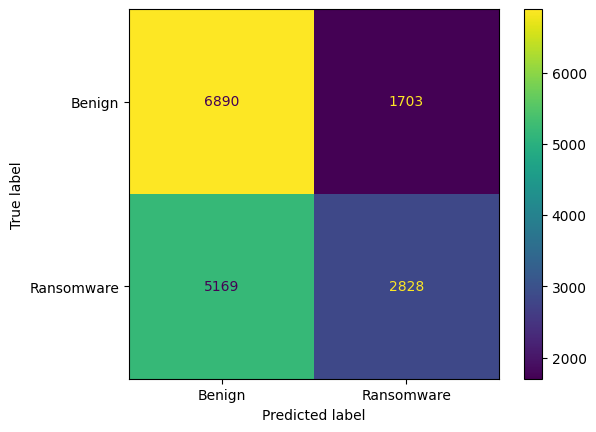

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the dataset
data = pd.read_csv("/content/Android_Ransomeware.csv")

# Step 1: Filter dataset to include only "Benign" and "RansomBO" samples
data = data[data['Label'].isin(['Benign', 'RansomBO'])]

# Step 2: Convert 'Label' to 0 for 'Benign' and 1 for 'RansomBO'
data['Label'] = data['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

# Step 3: Select the relevant network traffic columns
selected_columns = [
    ' ACK Flag Count', ' Fwd Header Length.1', ' Avg Bwd Segment Size', ' Avg Fwd Segment Size',
    ' Average Packet Size', ' Down/Up Ratio', ' ECE Flag Count', ' CWE Flag Count', ' URG Flag Count',
    ' PSH Flag Count', 'Fwd Packets/s', ' RST Flag Count', ' SYN Flag Count', 'FIN Flag Count',
    ' Packet Length Variance', ' Packet Length Std', ' Packet Length Mean', ' Max Packet Length',
    ' Min Packet Length', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate',
    ' Bwd Avg Bytes/Bulk', ' Idle Max', ' Idle Std', 'Idle Mean', ' Active Min', ' Active Max'
]

# Step 4: Separate features and target
X = data[selected_columns]
y = data['Label']

# Step 5: Convert all columns to numeric and handle missing values
X = X.apply(pd.to_numeric, errors='coerce').fillna(X.mean())

# Step 6: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Reshape input data to fit CNN (batch_size, channels, height, width)
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1], 1)

# Step 8: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Step 9: Define the CNN Model
# Step 1: Modify the model architecture with additional layers
class ImprovedMalwareDetectionCNN(nn.Module):
    def __init__(self):
        super(ImprovedMalwareDetectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 1))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 1))  # Additional layer
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))
        self.dropout = nn.Dropout(p=0.4)
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)

        # Flattened size calculation
        self.flatten_size = self._get_flatten_size(X_train_tensor)

        self.fc1 = nn.Linear(self.flatten_size, 128)  # Increased nodes
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def _get_flatten_size(self, sample_input):
        with torch.no_grad():
            x = self.pool(self.batchnorm1(self.relu(self.conv1(sample_input))))
            x = self.pool(self.batchnorm2(self.relu(self.conv2(x))))
            x = self.pool(self.batchnorm3(self.relu(self.conv3(x))))  # Additional layer
            x = x.view(x.size(0), -1)
        return x.size(1)

    def forward(self, x):
        x = self.pool(self.batchnorm1(self.relu(self.conv1(x))))
        x = self.pool(self.batchnorm2(self.relu(self.conv2(x))))
        x = self.pool(self.batchnorm3(self.relu(self.conv3(x))))  # Additional layer
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Step 2: Update the learning rate and optimizer
model = ImprovedMalwareDetectionCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Lower learning rate and L2 regularization

# Step 3: Increase epochs and implement early stopping
num_epochs = 50
best_accuracy = 0
early_stop_patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validate on test set
    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test_tensor)
        predicted = torch.argmax(test_outputs, dim=1)
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)

        # Early stopping
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > early_stop_patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Test Accuracy: {accuracy * 100:.2f}%')

# Confusion matrix to evaluate performance
cm = confusion_matrix(y_test_tensor, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Ransomware'])
disp.plot()
plt.show()
